In [4]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import RobustScaler
import numpy as np
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import StackingClassifier

In [5]:
train = pd.read_csv(r"./../../data/raw/train.csv")
test = pd.read_csv(r"./../../data/raw/test.csv")

In [6]:
train.head()

,id,surgery,age,hospital_number,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,...,packed_cell_volume,total_protein,abdomo_appearance,abdomo_protein,surgical_lesion,lesion_1,lesion_2,lesion_3,cp_data,outcome
0,0,yes,adult,530001,38.1,132.0,24.0,cool,reduced,dark_cyanotic,...,57.0,8.5,serosanguious,3.4,yes,2209,0,0,no,died
1,1,yes,adult,533836,37.5,88.0,12.0,cool,normal,pale_cyanotic,...,33.0,64.0,serosanguious,2.0,yes,2208,0,0,no,euthanized
2,2,yes,adult,529812,38.3,120.0,28.0,cool,reduced,pale_pink,...,37.0,6.4,serosanguious,3.4,yes,5124,0,0,no,lived
3,3,yes,adult,5262541,37.1,72.0,30.0,cold,reduced,pale_pink,...,53.0,7.0,cloudy,3.9,yes,2208,0,0,yes,lived
4,4,no,adult,5299629,38.0,52.0,48.0,normal,normal,normal_pink,...,47.0,7.3,cloudy,2.6,no,0,0,0,yes,lived


In [7]:
test.head()

,id,surgery,age,hospital_number,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,...,abdomen,packed_cell_volume,total_protein,abdomo_appearance,abdomo_protein,surgical_lesion,lesion_1,lesion_2,lesion_3,cp_data
0,1235,no,adult,534053,38.6,40.0,20.0,normal,normal,normal_pink,...,distend_small,42.0,7.5,clear,2.3,no,0,0,0,no
1,1236,yes,adult,528469,38.2,112.0,48.0,cool,reduced,bright_pink,...,distend_small,44.0,6.0,serosanguious,2.6,no,2208,0,0,yes
2,1237,yes,adult,528178,37.7,66.0,12.0,cool,normal,bright_red,...,distend_small,31.5,6.0,cloudy,1.6,yes,2205,0,0,yes
3,1238,no,adult,534784,37.1,88.0,20.0,cool,reduced,pale_cyanotic,...,distend_large,75.0,81.0,NaN,1.0,yes,1400,0,0,no
4,1239,yes,adult,529840,38.3,50.0,12.0,NaN,normal,bright_pink,...,distend_small,37.0,6.8,cloudy,2.6,yes,2208,0,0,yes


In [8]:
train.describe()

,id,hospital_number,rectal_temp,pulse,respiratory_rate,nasogastric_reflux_ph,packed_cell_volume,total_protein,abdomo_protein,lesion_1,lesion_2,lesion_3
count,1235.0000,1.235000e+03,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000
mean,617.0000,9.545004e+05,38.202186,79.574089,30.054251,4.382591,49.602429,21.388016,3.290931,3832.496356,14.612146,3.577328
std,356.6581,1.356403e+06,0.788668,29.108638,16.452066,1.937357,10.535800,26.676453,1.589195,5436.733774,193.705735,88.858953
min,0.0000,5.213990e+05,35.400000,30.000000,8.000000,1.000000,23.000000,3.500000,0.100000,0.000000,0.000000,0.000000
25%,308.5000,5.288000e+05,37.800000,53.000000,18.000000,2.000000,43.000000,6.600000,2.000000,2205.000000,0.000000,0.000000
50%,617.0000,5.297770e+05,38.200000,76.000000,28.000000,4.500000,48.000000,7.500000,3.000000,2209.000000,0.000000,0.000000
75%,925.5000,5.341450e+05,38.600000,100.000000,36.000000,6.000000,57.000000,9.100000,4.300000,3205.000000,0.000000,0.000000
max,1234.0000,5.305129e+06,40.800000,184.000000,96.000000,7.500000,75.000000,89.000000,10.100000,41110.000000,3112.000000,2209.000000


In [9]:
test.describe()

,id,hospital_number,rectal_temp,pulse,respiratory_rate,nasogastric_reflux_ph,packed_cell_volume,total_protein,abdomo_protein,lesion_1,lesion_2,lesion_3
count,824.000000,8.240000e+02,824.000000,824.000000,824.00000,824.000000,824.000000,824.000000,824.000000,824.000000,824.000000,824.0
mean,1646.500000,1.108357e+06,38.244539,80.229369,30.71966,4.508495,49.063350,20.796238,3.336420,3709.803398,12.391990,0.0
std,238.012605,1.555627e+06,0.785234,29.164711,17.43191,1.883464,10.450138,26.413588,1.539235,5112.931057,197.067771,0.0
min,1235.000000,5.213990e+05,36.000000,36.000000,9.00000,1.000000,23.000000,3.900000,0.100000,0.000000,0.000000,0.0
25%,1440.750000,5.287430e+05,37.800000,54.000000,18.00000,3.000000,43.000000,6.600000,2.000000,2205.000000,0.000000,0.0
50%,1646.500000,5.298085e+05,38.200000,76.000000,28.00000,4.500000,48.000000,7.500000,3.300000,2209.000000,0.000000,0.0
75%,1852.250000,5.346440e+05,38.600000,100.000000,36.00000,6.500000,55.000000,8.900000,4.300000,3205.000000,0.000000,0.0
max,2058.000000,5.305129e+06,40.800000,184.000000,96.00000,7.500000,75.000000,89.000000,10.100000,31110.000000,4300.000000,0.0


In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1235 entries, 0 to 1234
Data columns (total 29 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     1235 non-null   int64  
 1   surgery                1235 non-null   object 
 2   age                    1235 non-null   object 
 3   hospital_number        1235 non-null   int64  
 4   rectal_temp            1235 non-null   float64
 5   pulse                  1235 non-null   float64
 6   respiratory_rate       1235 non-null   float64
 7   temp_of_extremities    1196 non-null   object 
 8   peripheral_pulse       1175 non-null   object 
 9   mucous_membrane        1214 non-null   object 
 10  capillary_refill_time  1229 non-null   object 
 11  pain                   1191 non-null   object 
 12  peristalsis            1215 non-null   object 
 13  abdominal_distention   1212 non-null   object 
 14  nasogastric_tube       1155 non-null   object 
 15  naso

In [11]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 824 entries, 0 to 823
Data columns (total 28 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     824 non-null    int64  
 1   surgery                824 non-null    object 
 2   age                    824 non-null    object 
 3   hospital_number        824 non-null    int64  
 4   rectal_temp            824 non-null    float64
 5   pulse                  824 non-null    float64
 6   respiratory_rate       824 non-null    float64
 7   temp_of_extremities    789 non-null    object 
 8   peripheral_pulse       777 non-null    object 
 9   mucous_membrane        811 non-null    object 
 10  capillary_refill_time  818 non-null    object 
 11  pain                   795 non-null    object 
 12  peristalsis            805 non-null    object 
 13  abdominal_distention   802 non-null    object 
 14  nasogastric_tube       760 non-null    object 
 15  nasoga

In [12]:
train.isnull().sum()

id                         0
surgery                    0
age                        0
hospital_number            0
rectal_temp                0
pulse                      0
respiratory_rate           0
temp_of_extremities       39
peripheral_pulse          60
mucous_membrane           21
capillary_refill_time      6
pain                      44
peristalsis               20
abdominal_distention      23
nasogastric_tube          80
nasogastric_reflux        21
nasogastric_reflux_ph      0
rectal_exam_feces        190
abdomen                  213
packed_cell_volume         0
total_protein              0
abdomo_appearance         48
abdomo_protein             0
surgical_lesion            0
lesion_1                   0
lesion_2                   0
lesion_3                   0
cp_data                    0
outcome                    0
dtype: int64

In [13]:
test.isnull().sum()

id                         0
surgery                    0
age                        0
hospital_number            0
rectal_temp                0
pulse                      0
respiratory_rate           0
temp_of_extremities       35
peripheral_pulse          47
mucous_membrane           13
capillary_refill_time      6
pain                      29
peristalsis               19
abdominal_distention      22
nasogastric_tube          64
nasogastric_reflux        14
nasogastric_reflux_ph      0
rectal_exam_feces        125
abdomen                  154
packed_cell_volume         0
total_protein              0
abdomo_appearance         31
abdomo_protein             0
surgical_lesion            0
lesion_1                   0
lesion_2                   0
lesion_3                   0
cp_data                    0
dtype: int64

C:\Users\Satriock\AppData\Local\Temp\ipykernel_19056\3577316964.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='outcome', data=train, palette='viridis')


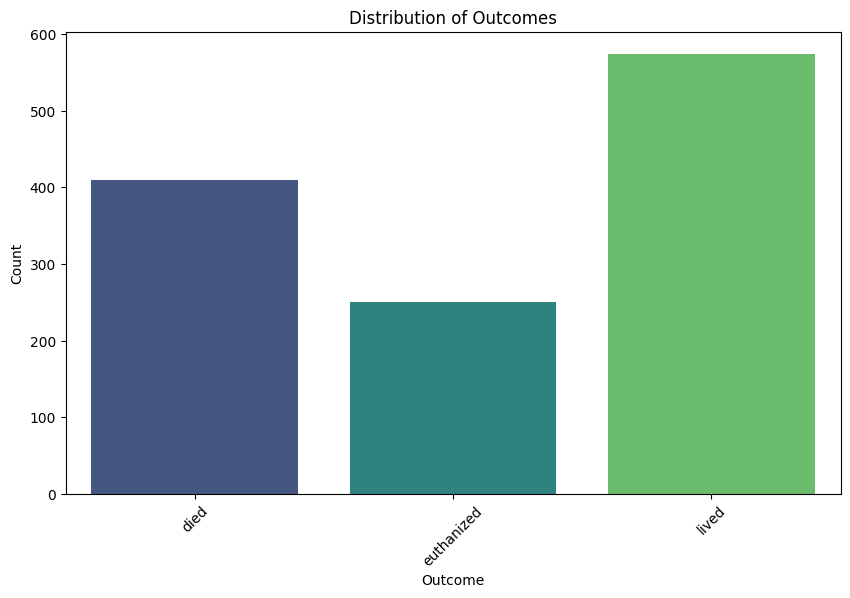

In [15]:
plt.figure(figsize=(10, 6))
sns.countplot(x='outcome', data=train, palette='viridis')
plt.title('Distribution of Outcomes')
plt.xlabel('Outcome')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

In [16]:
train_missing_cols = train.columns[train.isnull().any()] 
test_missing_cols = test.columns[test.isnull().any()]

train_missing_cols = list(train_missing_cols) 
test_missing_cols = list(test_missing_cols)

In [17]:
def replace_missing_with_most_common(data, columns):
    for column in columns:
        col_most_common = data[column].value_counts().index[0]
        data[column] = data[column].replace({np.nan: col_most_common})
    return data

train = replace_missing_with_most_common(train, train_missing_cols)
test = replace_missing_with_most_common(test,test_missing_cols)

In [18]:
numeric_train = train.select_dtypes(include = [np.number]) 
numeric_test = test.select_dtypes(include = [np.number])

categorical_train = train.select_dtypes(exclude = [np.number])
categorical_test = test.select_dtypes(exclude = [np.number])

In [19]:
train['surgery'] = train['surgery'].replace({'yes': 1,'no': 0})
train['age'] = train['age'].replace({'adult': 1,'young': 0})
train['surgical_lesion'] = train['surgical_lesion'].replace({'yes': 1,'no': 0})
train['cp_data'] = train['cp_data'].replace({'yes': 1,'no': 0})
train['outcome'] = train['outcome'].replace({'died': 0,'euthanized': 1,'lived': 2})

columns = ['temp_of_extremities','peripheral_pulse','mucous_membrane','capillary_refill_time','pain','peristalsis','abdominal_distention',
'nasogastric_tube','nasogastric_reflux','rectal_exam_feces','abdomen','abdomo_appearance']
train = pd.get_dummies(data = train,columns=columns)

In [20]:
test['surgery'] = test['surgery'].replace({'yes': 1,'no': 0})
test['age'] = test['age'].replace({'adult': 1,'young': 0})
test['surgical_lesion'] = test['surgical_lesion'].replace({'yes': 1,'no': 0})
test['cp_data'] = test['cp_data'].replace({'yes': 1,'no': 0})

test = pd.get_dummies(data = test,columns = ['temp_of_extremities','peripheral_pulse','mucous_membrane','capillary_refill_time','pain',
'peristalsis','abdominal_distention','nasogastric_tube','nasogastric_reflux','rectal_exam_feces','abdomen','abdomo_appearance'])

In [21]:
train.isnull().sum()

id                                 0
surgery                            0
age                                0
hospital_number                    0
rectal_temp                        0
                                  ..
abdomen_normal                     0
abdomen_other                      0
abdomo_appearance_clear            0
abdomo_appearance_cloudy           0
abdomo_appearance_serosanguious    0
Length: 69, dtype: int64

In [22]:
test.isnull().sum()

id                                 0
surgery                            0
age                                0
hospital_number                    0
rectal_temp                        0
                                  ..
abdomen_normal                     0
abdomen_other                      0
abdomo_appearance_clear            0
abdomo_appearance_cloudy           0
abdomo_appearance_serosanguious    0
Length: 65, dtype: int64

In [24]:
train.to_csv('./../../data/processed/cleaned_train.csv', index=False)
test.to_csv('./../../data/processed/cleaned_test.csv', index=False)